In [120]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys as sys
import os as os
import geocluster as gc
from geocluster import plotting
from graph_library import generate_barbell, generate_tree, generate_clique_of_cliques, assign_graph_metadata
import networkx as nx
import scipy as sc
import pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FFMpegWriter
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clique of cliques

In [ ]:
w = list(nx.get_edge_attributes(graph, 'weight').values())
plotting.plot_graph(graph,w,node_size=20,edge_width=1,node_labels=False,node_colors=None,figsize=(10, 7),color_map=1)

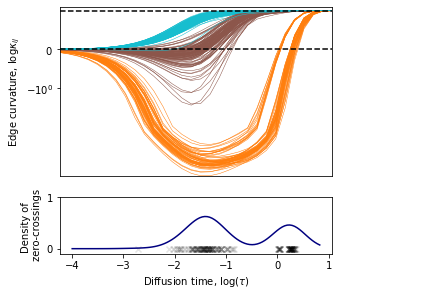

In [267]:
graph, pos = generate_clique_of_cliques(params = {'m':5, 'n': 3, 'L': 500, 'w':[1, 5, 10], 'p':[0.01, 0.1, 1]},
                                                  seed=0)
        
# initialise the code with parameters and graph 
graph.graph['name'] = 'clique_of_cliques'
graph = assign_graph_metadata(graph, pos=pos)

times = np.logspace(-4., 1., 30)
params = {'n_workers': 10, 'GPU': False, 'lambda': 0, 
          'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': True}

#Compute the OR curvatures
kappas = gc.compute_curvatures(graph, times, params, disable=True)

#Plot
w = list(nx.get_edge_attributes(graph, 'weight').values())
fig = plotting.plot_edge_curvatures(times, kappas, edge_color = w, ylog=True, filename = 'CoC') 
#plotting.plot_graph_snapshots(graph, times, kappas, filename = 'CoC', disable=True)

# Number of induced cycles

In [187]:
def dfs(graph, start, end, limit=3):
    fringe = [(start, [])]
    while fringe:
        state, path = fringe.pop()
        if path and state == end:
            yield path
            continue
        if len(path)<limit:
            for next_state in graph[state]:
                if next_state in path:
                    continue
                fringe.append((next_state, path+[next_state]))  

def isCircular(arr1, arr2):
    if len(arr1) != len(arr2):
        return False

    str1 = ' '.join(map(str, arr1))
    str2 = ' '.join(map(str, arr2))
    if len(str1) != len(str2):
        return False

    return str1 in str2 + ' ' + str2 

def is_sub(sub, lst):
    ln = len(sub)
    for i in range(len(lst) - ln + 1):
        if all(sub[j] == lst[i+j] for j in range(ln)):
            return True
    return False

In [192]:
#G = { 1: [2, 3, 5], 2: [1], 3: [1], 4: [2], 5: [2] }

#generate a dictionary of neighbours
G = {}
for i in graph.nodes:
    G[i] = [n for n in graph.neighbors(i)]

#find all cycles
#cycles = [[node]+path for node in G for path in dfs(G, node, node)]
cycles = []
for node in tqdm(G):
    for path in dfs(G, node, node, limit=3):
        cycles.append([node]+path)

#remove cyclically identical cycles
step = 0
while step<=len(cycles):
    for cyc2 in cycles[step+1:]:
        cyc1 = cycles[step]
        if isCircular(np.array(cyc1[:-1]), np.array(cyc2[:-1])):
            cycles.remove(cyc2)
    step+=1        
    
#count how many cycles it is contained in
counts = {}
for i, edge in enumerate(graph.edges):
    edge = list(edge)
    counts[i] = 0
    for cycle in cycles:
        if is_sub(edge, cycle):
            counts[i] += 1





100%|██████████| 64/64 [00:00<00:00, 36586.54it/s]


# Vary size of barbells

  0%|          | 0/20 [00:00<?, ?it/s]

All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.


 89%|████████▉ | 17/19 [00:00<00:00, 77.31it/s]

All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.


100%|██████████| 19/19 [00:00<00:00, 46.28it/s]


All edges have positive curvatures, so you may stop the computations.


100%|██████████| 19/19 [00:00<00:00, 25.28it/s]

All edges have positive curvatures, so you may stop the computations.
All edges have positive curvatures, so you may stop the computations.



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


IndexError: list index out of range

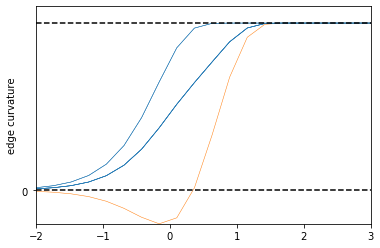

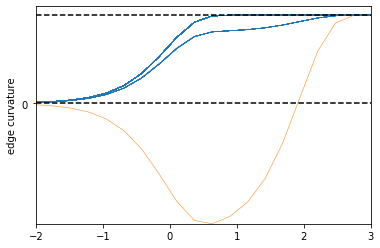

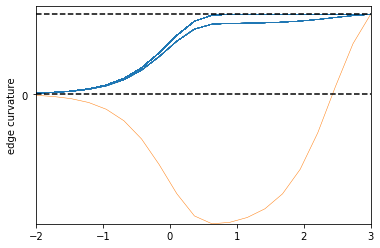

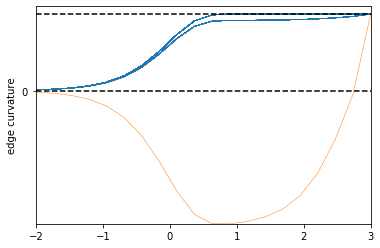

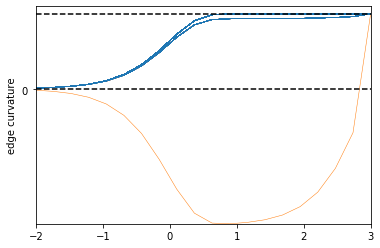

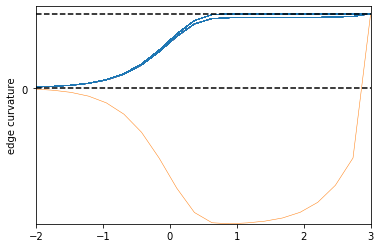

In [7]:
#Generate graph 
params_gg = [{'m1': i, 'm2': 0} for i in range(3,60,10)]
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 10, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_1 = {}
for i in range(len(params_gg)):
    graph,_ = generate_barbell(params_gg[i])
        
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_1[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_1[i], ylog=True, filename = 'barbell_' + str(i))
    plotting.plot_graph_snapshots(graph, times, kappas_1[i], filename = 'barbell_' + str(i))

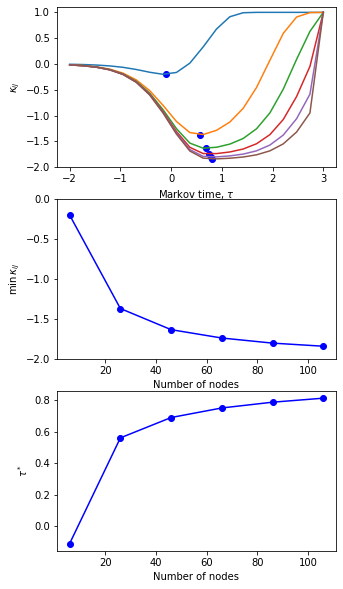

In [209]:
min_kappa_1 = [kappas_1[i].min() for i in range(len(kappas_1))]
n = [2*params_gg[i]['m1'] for i in range(len(kappas_1))]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,10))

#plt.savefig('vary_m1.svg')
from scipy.interpolate import InterpolatedUnivariateSpline

kappa_mins = []
inds = []
tau_star = []
for i in range(len(kappas_1)):
    edge_ind = np.where(kappas_1[i]==np.min(kappas_1[i]))[1]
    kappa_between_edge = kappas_1[i][:, edge_ind]
    kappa_mins.append(kappa_between_edge) 
       
    f = InterpolatedUnivariateSpline(np.log10(times), kappa_between_edge.flatten(), k=4)
    cr_pts = f.derivative().roots()
    cr_vals = f(cr_pts)
    ind = np.argmin(cr_vals)
    inds.append(cr_pts[ind])

    tau_star.append(cr_pts[ind])
    ax1.plot(np.log10(times), kappa_between_edge)
    ax1.scatter(cr_pts[ind], np.min(cr_vals), c='b')
 
ax2.plot(n, min_kappa_1, 'b-o')
ax3.plot(n, tau_star, 'b-o')

ax1.set_ylim([-2., 1.1])
ax1.set_xlabel(r'Markov time, $\tau$')
ax1.set_ylabel(r'$\kappa_{ij}$')
ax2.set_xlabel('Number of nodes')
ax2.set_ylabel(r'$\min \,\kappa_{ij}$')
ax2.set_ylim([-2., 0])
ax3.set_xlabel('Number of nodes')
ax3.set_ylabel(r'$\tau^*$')

plt.show()

# Vary number of edges between barbells

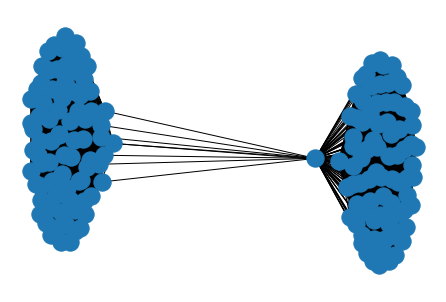

In [13]:
nonedges = list(nx.non_edges(graph))
graph.add_edge(nonedges[0][0], nonedges[0][1])
nx.number_of_edges(graph)
nx.draw(graph)


100%|██████████| 19/19 [00:22<00:00,  1.19s/it]

100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


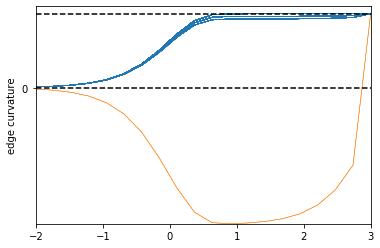

Process ForkPoolWorker-42:
Process ForkPoolWorker-33:
Process ForkPoolWorker-47:
Process ForkPoolWorker-41:
Process ForkPoolWorker-36:
Process ForkPoolWorker-35:
Process ForkPoolWorker-45:
Process ForkPoolWorker-37:
Process ForkPoolWorker-40:
Process ForkPoolWorker-34:
Process ForkPoolWorker-44:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-48:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-38:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gosztolai/anaconda

  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __

In [5]:
#Generate graph 
params_2 = np.ceil(np.logspace(0,2,10)).astype(int)
graph,_ = generate_barbell({'m1': 80, 'm2': 0})    
    
#Generate graph 
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 16, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_2 = {}
for i in range(1):
    nonedges = list(nx.non_edges(graph))
    graph = graph.add_edge(nonedges[0][0], nonedges[0][1])
       
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_2[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_2[i], ylog=True, filename = 'barbell_2_' + str(i))
    plotting.plot_graph_snapshots(graph, times, kappas_2[i], filename = 'barbell_2_' + str(i))

In [ ]:
min_kappa_2 = [kappas_2[i].min() for i in range(len(kappas_2))]
l = [2*params_2[i]['m2'] for i in range(len(kappas_2))]
plt.plot(l, min_kappa_2)
plt.xlabel('Length of bottleneck')
plt.ylabel(r'$\min\, \kappa_{ij}$')
plt.savefig('vary_m2.svg')
plt.show()

# Vary weight of single edge between barbells



  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:00<00:09,  1.94it/s]

 11%|█         | 2/19 [00:00<00:07,  2.24it/s]

 16%|█▌        | 3/19 [00:01<00:07,  2.20it/s]

 21%|██        | 4/19 [00:01<00:07,  2.02it/s]

 26%|██▋       | 5/19 [00:02<00:07,  1.89it/s]

 32%|███▏      | 6/19 [00:05<00:15,  1.16s/it]

 37%|███▋      | 7/19 [00:07<00:19,  1.60s/it]

 42%|████▏     | 8/19 [00:10<00:20,  1.86s/it]

 47%|████▋     | 9/19 [00:12<00:19,  1.94s/it]

 53%|█████▎    | 10/19 [00:13<00:16,  1.85s/it]

 58%|█████▊    | 11/19 [00:15<00:14,  1.85s/it]

 63%|██████▎   | 12/19 [00:17<00:12,  1.85s/it]

 68%|██████▊   | 13/19 [00:19<00:10,  1.82s/it]

 74%|███████▎  | 14/19 [00:21<00:08,  1.78s/it]

 79%|███████▉  | 15/19 [00:21<00:05,  1.49s/it]

 84%|████████▍ | 16/19 [00:22<00:03,  1.32s/it]

All edges have positive curvatures, so you may stop the computations.




 89%|████████▉ | 17/19 [00:24<00:02,  1.28s/it]

All edges have positive curvatures, so you may stop the computations.




 95%|█████████▍| 18/19 [00:25<00:01,  1.30s/it]

All edges have positive curvatures, so you may stop the computations.




100%|██████████| 19/19 [00:27<00:00,  1.42s/it]

All edges have positive curvatures, so you may stop the computations.





  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:00<00:09,  1.92it/s]

 11%|█         | 2/19 [00:01<00:09,  1.84it/s]

 16%|█▌        | 3/19 [00:01<00:09,  1.76it/s]

 21%|██        | 4/19 [00:02<00:08,  1.72it/s]

 26%|██▋       | 5/19 [00:02<00:07,  1.98it/s]

 32%|███▏      | 6/19 [00:05<00:14,  1.10s/it]

 37%|███▋      | 7/19 [00:07<00:15,  1.32s/it]

 42%|████▏     | 8/19 [00:09<00:17,  1.56s/it]

 47%|████▋     | 9/19 [00:11<00:17,  1.71s/it]

 53%|█████▎    | 10/19 [00:13<00:17,  1.90s/it]

 58%|█████▊    | 11/19 [00:15<00:15,  1.96s/it]

 63%|██████▎   | 12/19 [00:17<00:13,  1.95s/it]

 68%|██████▊   | 13/19 [00:19<00:11,  1.99s/it]

 74%|███████▎  | 14/19 [00:21<00:09,  1.95s/it]

 79%|███████▉  | 15/19 [00:22<00:06,  1.65s/it]

 84%|████████▍ | 16/19 [00:23<00:04,  1.44s/it]

 89%|████████▉ | 17/19 [00:24<00:02,  1.38s/it]

All edges have positive curvatures, so you may stop the computations.




 95%|█████████▍| 18/19 [00:26<00:01,  1.40s/it]

All edges have positive curvatures, so you may stop the computations.




100%|██████████| 19/19 [00:27<00:00,  1.46s/it]

All edges have positive curvatures, so you may stop the computations.





  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:00<00:09,  1.94it/s]

 11%|█         | 2/19 [00:00<00:08,  2.12it/s]

 16%|█▌        | 3/19 [00:01<00:07,  2.01it/s]

 21%|██        | 4/19 [00:01<00:06,  2.24it/s]

 26%|██▋       | 5/19 [00:02<00:05,  2.43it/s]

 32%|███▏      | 6/19 [00:04<00:13,  1.01s/it]

 37%|███▋      | 7/19 [00:05<00:13,  1.15s/it]

 42%|████▏     | 8/19 [00:07<00:14,  1.34s/it]

 47%|████▋     | 9/19 [00:09<00:14,  1.46s/it]

 53%|█████▎    | 10/19 [00:11<00:14,  1.65s/it]

 58%|█████▊    | 11/19 [00:13<00:13,  1.65s/it]

 63%|██████▎   | 12/19 [00:15<00:12,  1.80s/it]

 68%|██████▊   | 13/19 [00:16<00:10,  1.74s/it]

 74%|███████▎  | 14/19 [00:18<00:08,  1.74s/it]

 79%|███████▉  | 15/19 [00:19<00:05,  1.48s/it]

 84%|████████▍ | 16/19 [00:20<00:03,  1.32s/it]

 89%|████████▉ | 17/19 [00:21<00:02,  1.29s/it]

 95%|█████████▍| 18/19 [00:23<00:01,  1.32s/it]

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]

All edges have positive curvatures, so you may stop the computations.





  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:00<00:09,  1.92it/s]

 11%|█         | 2/19 [00:01<00:09,  1.86it/s]

 16%|█▌        | 3/19 [00:01<00:07,  2.02it/s]

 21%|██        | 4/19 [00:01<00:06,  2.14it/s]

 26%|██▋       | 5/19 [00:02<00:06,  2.31it/s]

 32%|███▏      | 6/19 [00:02<00:05,  2.54it/s]

 37%|███▋      | 7/19 [00:03<00:07,  1.53it/s]

 42%|████▏     | 8/19 [00:04<00:08,  1.28it/s]

 47%|████▋     | 9/19 [00:06<00:10,  1.02s/it]

 53%|█████▎    | 10/19 [00:08<00:11,  1.24s/it]

 58%|█████▊    | 11/19 [00:10<00:11,  1.44s/it]

 63%|██████▎   | 12/19 [00:11<00:10,  1.55s/it]

 68%|██████▊   | 13/19 [00:13<00:09,  1.62s/it]

 74%|███████▎  | 14/19 [00:15<00:08,  1.73s/it]

 79%|███████▉  | 15/19 [00:16<00:05,  1.50s/it]

 84%|████████▍ | 16/19 [00:17<00:04,  1.34s/it]

 89%|████████▉ | 17/19 [00:18<00:02,  1.30s/it]

 95%|█████████▍| 18/19 [00:20<00:01,  1.33s/it]

100%|██████████| 19/19 [00:21<00:00,  1.16s/it]


  0%|          | 0/19 [00:00<?, ?i

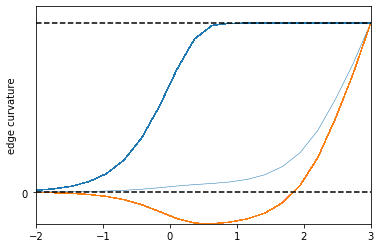

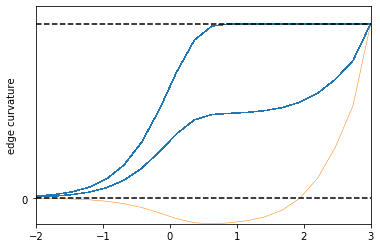

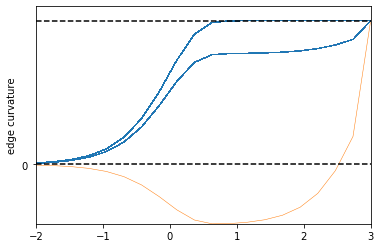

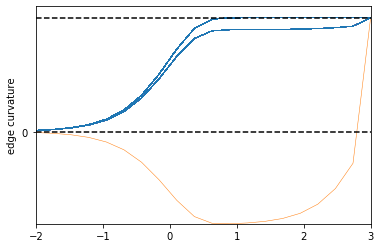

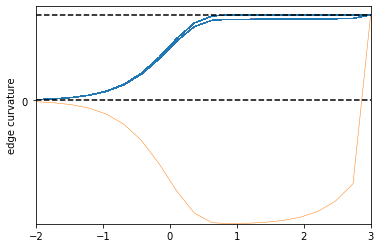

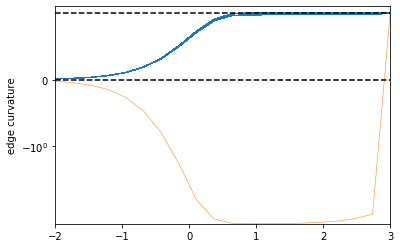

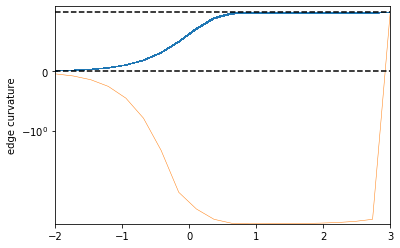

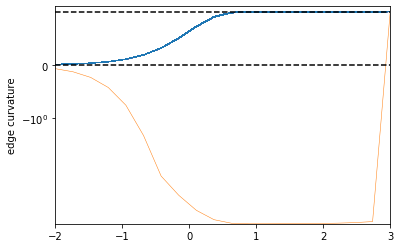

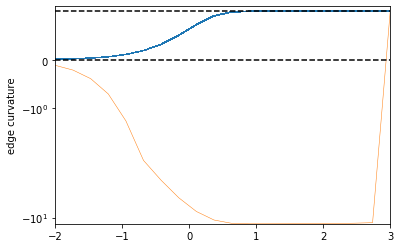

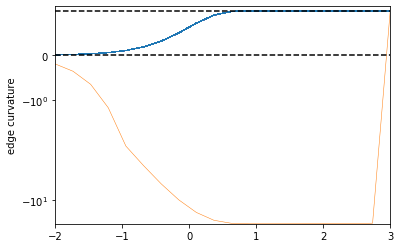

Process ForkPoolWorker-795:
Process ForkPoolWorker-727:
Process ForkPoolWorker-783:
Process ForkPoolWorker-746:
Process ForkPoolWorker-758:
Process ForkPoolWorker-732:
Process ForkPoolWorker-766:
Process ForkPoolWorker-812:
Process ForkPoolWorker-753:
Process ForkPoolWorker-778:
Process ForkPoolWorker-820:
Process ForkPoolWorker-791:
Process ForkPoolWorker-837:
Process ForkPoolWorker-852:
Process ForkPoolWorker-816:
Process ForkPoolWorker-789:
Process ForkPoolWorker-720:
Process ForkPoolWorker-712:
Process ForkPoolWorker-792:
Process ForkPoolWorker-723:
Process ForkPoolWorker-776:
Process ForkPoolWorker-823:
Process ForkPoolWorker-801:
Process ForkPoolWorker-785:
Process ForkPoolWorker-861:
Process ForkPoolWorker-869:
Process ForkPoolWorker-819:
Process ForkPoolWorker-715:
Process ForkPoolWorker-805:
Process ForkPoolWorker-815:
Process ForkPoolWorker-737:
Process ForkPoolWorker-744:
Process ForkPoolWorker-806:
Process ForkPoolWorker-772:
Process ForkPoolWorker-718:
Process ForkPoolWork

  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gosztolai/anaconda3/lib

  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get

  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/gosztolai/anacon

KeyboardInterrupt
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/gosztolai/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-786:
Process ForkPoolWorker-814:
Process ForkPoolWorker-817:
Process ForkPoolWorker-839:
Process ForkPoolWorker-863:
Process ForkPoolWorker-867:
Process ForkPoolWorker-841:
Process ForkPoolWorker-810:
Process ForkPoolWorker-811:
Process ForkPoolWorker-842:
Process ForkPoolWorker-829:
Process ForkPoolWorker-796:
Process ForkPoolWorker-828:
Process ForkPoolWorker-854:
Process ForkPoolWorker-843:
Process ForkPoolWorker-851:
Process ForkPoolWorker-7

In [204]:
#Generate graph 
params_3 = np.logspace(-1,1,10)
graph,_ = generate_barbell({'m1': 80, 'm2': 0})    
    
#Generate graph 
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 16, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_3 = {}
for i in range(len(params_3)):
    A = nx.adjacency_matrix(graph).astype(float)
    A[79,80] = 1/params_3[i]
    A[80,79] = 1/params_3[i]
    graph = nx.from_numpy_matrix(A.todense())
       
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_3[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_3[i], ylog=True, filename = 'barbell_3_' + str(i))

[-19.68748088 -19.678844   -19.68229261 -19.62194166 -19.69213496
 -19.32694729 -20.08902997]
[-0.18948143]
[-0.14880113]
[-0.41447149]
[-0.81201219]
[-1.44373533]
[-2.47709709 -2.24375133 -2.25069129]
[-4.18800969 -3.96363482 -4.03714669]
[-7.03409284 -6.97907458 -6.98600564 -6.79465798 -6.99339473]
[-11.77692076 -11.77691153 -11.77709804 -11.76815663 -11.76820241
 -11.72026294 -11.74985894 -11.49628046 -11.90624062]


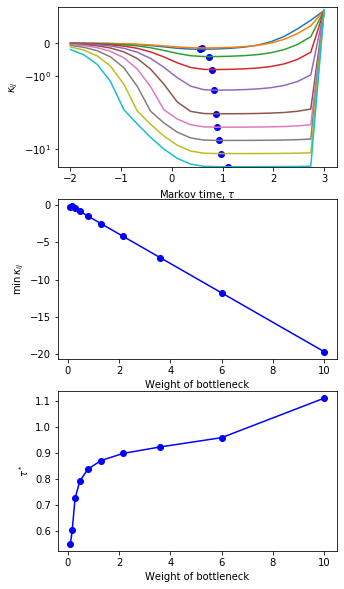

In [219]:
min_kappa = [kappas_3[i].min() for i in range(len(kappas_3))]
w = [params_3[i] for i in range(len(kappas_3))]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,10))

from scipy.interpolate import InterpolatedUnivariateSpline

kappa_mins = []
inds = []
tau_star = []
for i in range(len(kappas_3)):
    edge_ind = np.where(kappas_3[i]==np.min(kappas_3[i]))[1]
    if len(edge_ind)>0:
        edge_ind = edge_ind[0]
    kappa_between_edge = kappas_3[i][:, edge_ind]
    kappa_mins.append(kappa_between_edge) 
       
    f = InterpolatedUnivariateSpline(np.log10(times), kappa_between_edge.flatten(), k=4)
    cr_pts = f.derivative().roots()
    print(cr_vals)
    cr_vals = f(cr_pts)
    ind = np.argmin(cr_vals)
    inds.append(cr_pts[ind])

    tau_star.append(cr_pts[0])
    ax1.plot(np.log10(times), kappa_between_edge)
    ax1.scatter(cr_pts[0], np.min(cr_vals), c='b')
 
ax2.plot(w, min_kappa, 'b-o')
ax3.plot(w, tau_star, 'b-o')

ax1.set_ylim([-20., 1.1])
ax1.set_yscale('symlog')
ax1.set_xlabel(r'Markov time, $\tau$')
ax1.set_ylabel(r'$\kappa_{ij}$')
ax2.set_xlabel('Weight of bottleneck')
ax2.set_ylabel(r'$\min \,\kappa_{ij}$')
#ax2.set_ylim([-2., 1.1])
ax3.set_xlabel('Weight of bottleneck')
ax3.set_ylabel(r'$\tau^*$')
#ax3.set_ylim([-0., 3])

plt.show()

# Vary number of connections between barbells

In [ ]:
#Generate graph 
params_4 = np.logspace(-1,2,10)

graph,_ = generate_barbell({'m1': 120, 'm2': 0})    
    
#Generate graph 
times = np.logspace(-2., 3., 20)
params_gc = {'n_workers': 10, 'GPU': False, 'lambda': 0, 
             'with_weights': False, 'cutoff': 1.-1e-8, 'use_spectral_gap': False}

kappas_3 = {}
for i in range(len(params_3)):
    A = nx.adjacency_matrix(graph).astype(float)
    A[119,120] = 1/params_3[i]
    A[120,119] = 1/params_3[i]
    graph = nx.from_numpy_matrix(A.todense())
       
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'barbell'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    #Compute the OR curvatures are all the times
    kappas_3[i] = gc.compute_curvatures(graph, times, params_gc, save=False)            

    #Plot
    plotting.plot_edge_curvatures(times, kappas_4[i], ylog=True, filename = 'barbell_4_' + str(i))
    plotting.plot_graph_snapshots(graph, times, kappas_4[i], filename = 'barbell_4_' + str(i))    

# Vary height of tree

In [ ]:
#Generate graph 
params_1 = [{'r': 2, 'h': i} for i in range(2,7)]

kappas_1 = {}
for i in range(len(params_1)):
    graph,_ = generate_tree(params_1[i])
        
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'tree'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    # initialise the code with parameters and graph
    gc = GeoCluster(graph, T=np.logspace(-2., 3., 20), use_spectral_gap = False)
                 
    #Compute the OR curvatures are all the times
    gc.compute_OR_curvatures(save=False)
    kappas_1[i] = gc.Kappa
    gc.pos = [pos[i] for i in range(len(pos))]

    #Save results for later analysis
    gc.plot_edge_curvature(filename = 'tree_1_' + str(i), log=False)
    gc.plot_graph_snapshots(filename = 'tree_1_' + str(i), edge_width=1, node_size=10)

# Vary branching factor of tree

In [ ]:
#Generate graph 
params_2 = [{'r': i, 'h': 5} for i in range(2,7)]

kappas_2 = {}
for i in range(len(params_2)):
    graph,_ = generate_tree(params_2[i])
        
    # initialise the code with parameters and graph 
    graph.graph['name'] = 'tree'
    pos = nx.spring_layout(graph, weight='weight')
    graph = assign_graph_metadata(graph, pos=pos)

    # initialise the code with parameters and graph
    gc = GeoCluster(graph, T=np.logspace(-2., 3., 20), use_spectral_gap = False)
                 
    #Compute the OR curvatures are all the times
    gc.compute_OR_curvatures(save=False)
    kappas_2[i] = gc.Kappa
    gc.pos = [pos[i] for i in range(len(pos))]

    #Save results for later analysis
    gc.plot_edge_curvature(filename = 'tree_2_' + str(i), log=False)
    gc.plot_graph_snapshots(filename = 'tree_2_' + str(i), edge_width=1, node_size=10)